<a href="https://www.kaggle.com/code/baseershah/data-preprocessing-for-gbdt-performance-increase?scriptVersionId=252249366" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Prerequisites

> **with these data cleaning steps my lb score with base lgbm improved from 72,732 to 72,509**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
# from sklearn.svm import SVR
# from sklearn.ensemble import (RandomForestRegressor, VotingRegressor, StackingRegressor, 
#                                ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor)
from sklearn.model_selection import train_test_split, KFold, cross_val_score
# from sklearn.feature_selection import mutual_info_regression
#from sklearn.metrics import mean_absolute_error, root_mean_squared_error, make_scorer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [2]:
seed = 42

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv', index_col=[0])
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

# Data Understanding

In [4]:
from IPython.display import display
def highlight_non_zero(val):
    if val > 0:
        return 'background-color: purple'  
    return ''

def check_missing_values(train, test):
    df = []
    for col in train.columns:
        if col!='price':
            null_values=test[col].isnull().sum()
            missing_percentage = ((null_values/train.shape[0])*100)
            df.append(['Train', col, null_values, missing_percentage])
    for col in test.columns:
        null_values=test[col].isnull().sum()
        missing_percentage = ((null_values/train.shape[0])*100)
        df.append(['Test', col, null_values, missing_percentage])
    
    df = pd.DataFrame(df, columns = ['Dataset', 'Cols', 'Missing_values', 'Missing_percentage'])
    styled_df = (df.style
                 .map(highlight_non_zero, subset=['Missing_values', 'Missing_percentage']))
    return display(styled_df)

check_missing_values(train, test)

,Dataset,Cols,Missing_values,Missing_percentage
0,Train,brand,0,0.000000
1,Train,model,0,0.000000
2,Train,model_year,0,0.000000
3,Train,milage,0,0.000000
4,Train,fuel_type,3383,1.794381
5,Train,engine,0,0.000000
6,Train,transmission,0,0.000000
7,Train,ext_col,0,0.000000
8,Train,int_col,0,0.000000
9,Train,accident,1632,0.865631


fuel_type, accident, and clean_title only cols with missing values,
so lets check their value counts

In [5]:
def highlight_nunique_values(val):
    if val < 2000:
        return 'background-color: purple'  
    return ''
def check_unique_values(train, test):
    data = []
    for col in train.columns:
        if col!='price':
            unique_values = train[col].nunique()
            data.append(['Train', col, unique_values])
    for col in test.columns:
        unique_values = test[col].nunique()
        data.append(['Test', col, unique_values])
    data = pd.DataFrame(data, columns=['DF', 'column', 'n_unique_values'])
    styled_data = data.style.map(highlight_nunique_values, subset=['n_unique_values'])
    display(styled_data)
check_unique_values(train, test)

,DF,column,n_unique_values
0,Train,brand,57
1,Train,model,1897
2,Train,model_year,34
3,Train,milage,6651
4,Train,fuel_type,7
5,Train,engine,1117
6,Train,transmission,52
7,Train,ext_col,319
8,Train,int_col,156
9,Train,accident,2


In [6]:
cols_with_nan = ['fuel_type', 'accident', 'clean_title']
print('value_counts for train df columns: ')
for col in cols_with_nan:
    print(train[col].value_counts())
    print('*'*50)

value_counts for train df columns: 
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64
**************************************************
accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64
**************************************************
clean_title
Yes    167114
Name: count, dtype: int64
**************************************************


* --fuel_type has multiple options for imputations
* --clean title with only Yes value( should be dropped)
* --accident col has two values but its difficult to impute this col due to non relevancy with other features

# Clean_title

Lets start by checking if there is any diff between the distributions by price for clean title with nan values and 'Yes'  value

In [7]:
# making a dummy df wiht clean_titled null values imputed with 'nan' string
dummy_train = train.copy()
dummy_train['clean_title']=dummy_train['clean_title'].fillna('nan')

dummy_test = test.copy()
dummy_test['clean_title']=dummy_test['clean_title'].fillna('nan')

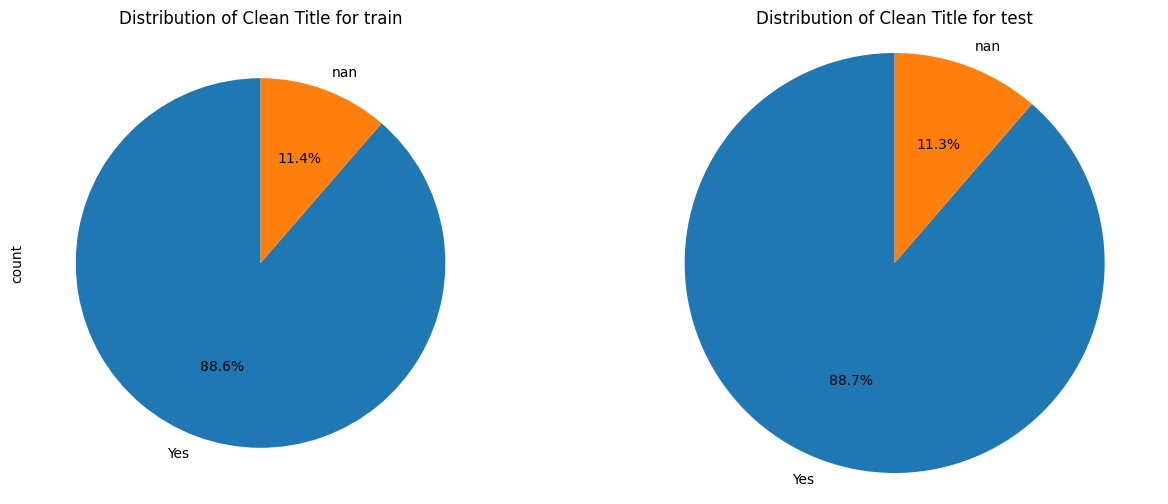

In [8]:
train_counts = dummy_train['clean_title'].value_counts()
test_counts = dummy_test['clean_title'].value_counts()
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
train_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Clean Title for train')
plt.subplot(1,2,2)
test_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Clean Title for test')
plt.ylabel('')
plt.axis('equal') 
plt.show()

Text(0.5, -0.05, 'Not much difference, I\'d say, since rows with NaN values are significantly less compared to rows with "Yes".')

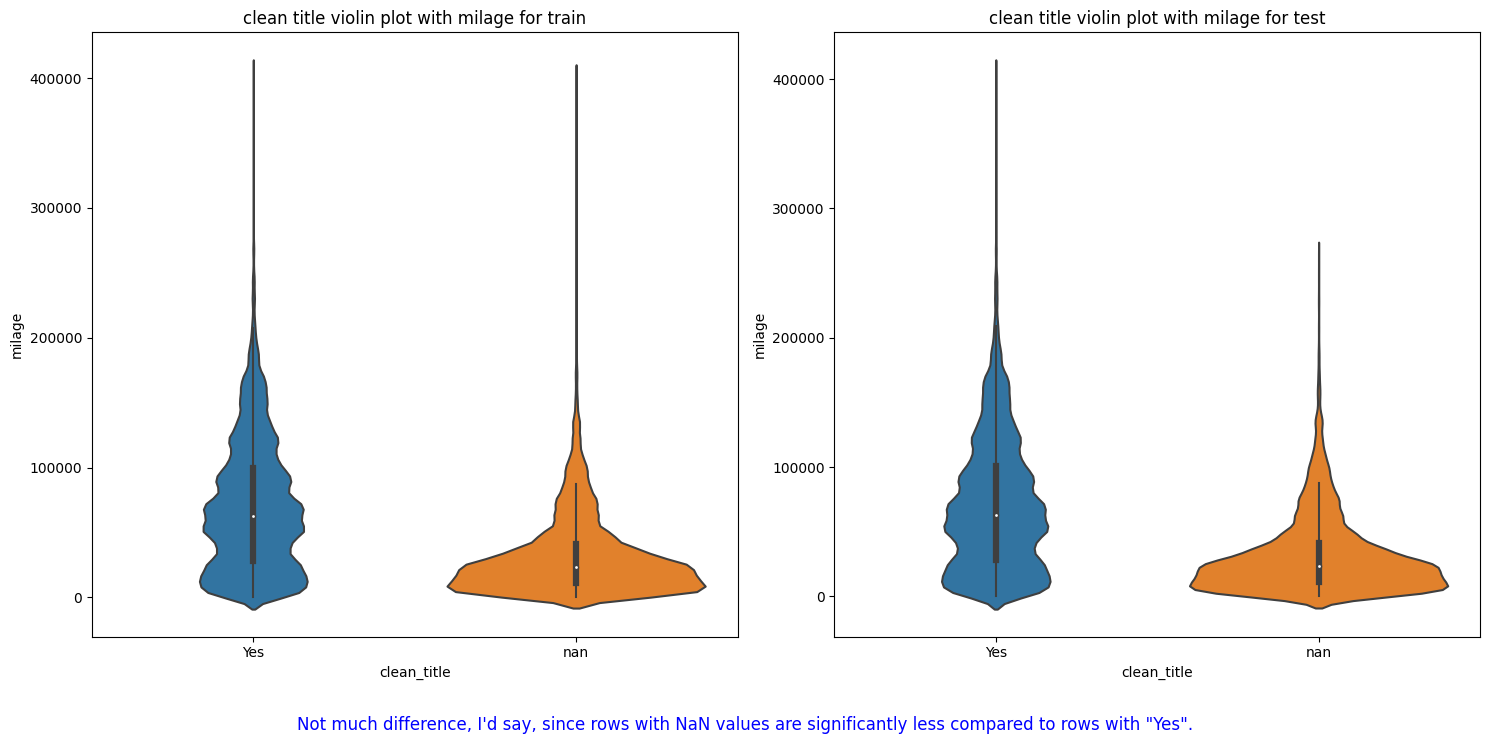

In [9]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.violinplot(x='clean_title', y='milage', data=dummy_train)
plt.title('clean title violin plot with milage for train')
plt.subplot(1,2,2)
sns.violinplot(x='clean_title', y='milage', data=dummy_test)
plt.title('clean title violin plot with milage for test')
plt.tight_layout()
plt.figtext(0.5, -0.05, 'Not much difference, I\'d say, since rows with NaN values are significantly less compared to rows with "Yes".', 
            ha='center', fontsize=12, color='blue')

lets also check clean_title with price for train

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, -0.05, 'Yes value has way more high prices points compared to nan but it also has way more way more rows.')

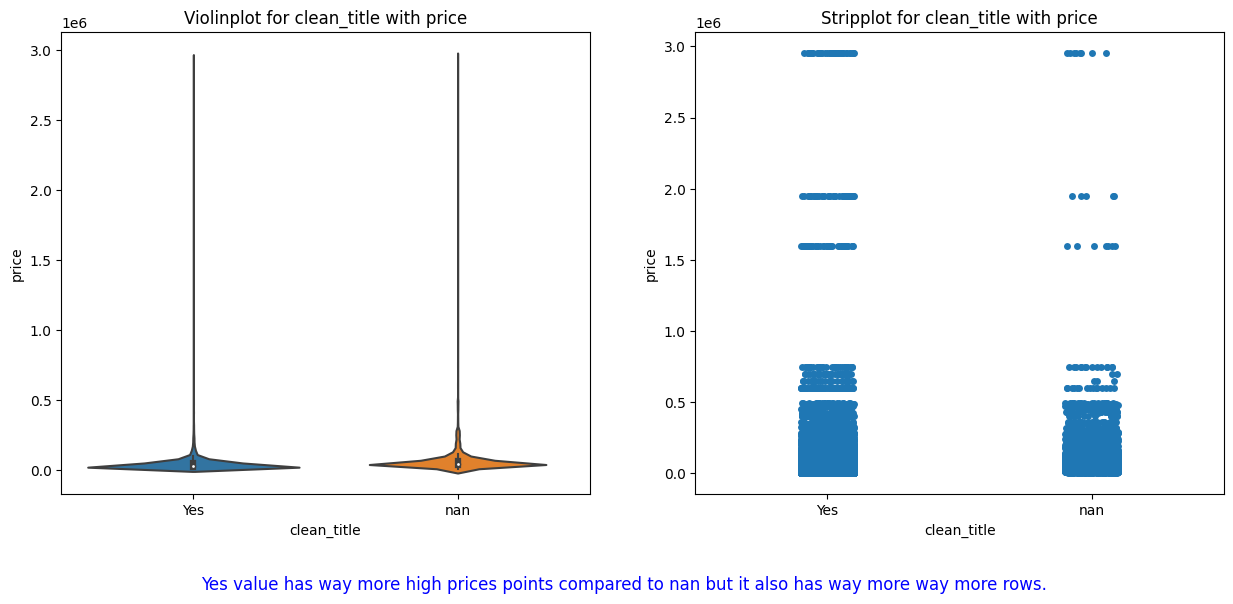

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.violinplot(x='clean_title', y='price', data=dummy_train)
plt.title('Violinplot for clean_title with price')
plt.subplot(1,2,2)
sns.stripplot(x='clean_title', y='price', data=dummy_train)
plt.title('Stripplot for clean_title with price')
plt.figtext(0.5, -0.05, 'Yes value has way more high prices points compared to nan but it also has way more way more rows.', 
            ha='center', fontsize=12, color='blue')

'Yes' value has way more high prices points compared to nan but it also has way more way more rows.
I have tried various methods for imputation for clean_title with base lgbm and dropping it yielded the best results

In [11]:
# drop the clean_title from both train and test

train.drop(columns=['clean_title'], inplace=True)
test.drop(columns=['clean_title'], inplace=True)

# Accident

In [12]:
print('average for accident with price for train :', dummy_train.groupby('accident')['price'].mean())

average for accident with price for train : accident
At least 1 accident or damage reported    25334.071475
None reported                             49024.804144
Name: price, dtype: float64


major difference in price between no accident and reported accidents, the price drops significantly if price is dropped. We can divide thhem with a threshold and then proceed with imputation but it can results in more noise so lets just leave accident as it is.

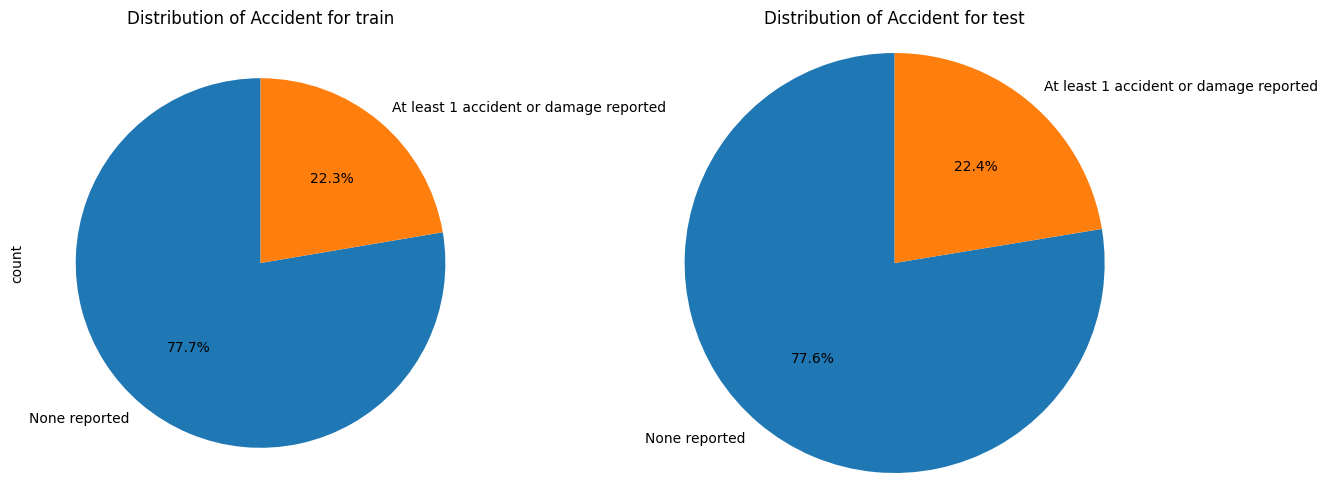

In [13]:
train_counts = dummy_train['accident'].value_counts()
test_counts = dummy_test['accident'].value_counts()

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
train_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Accident for train')
plt.subplot(1,2,2)
test_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Accident for test')
plt.ylabel('')
plt.axis('equal') 
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, -0.05, '"Yes" value has way more high prices points compared to nan but it also has way more way more rows.')

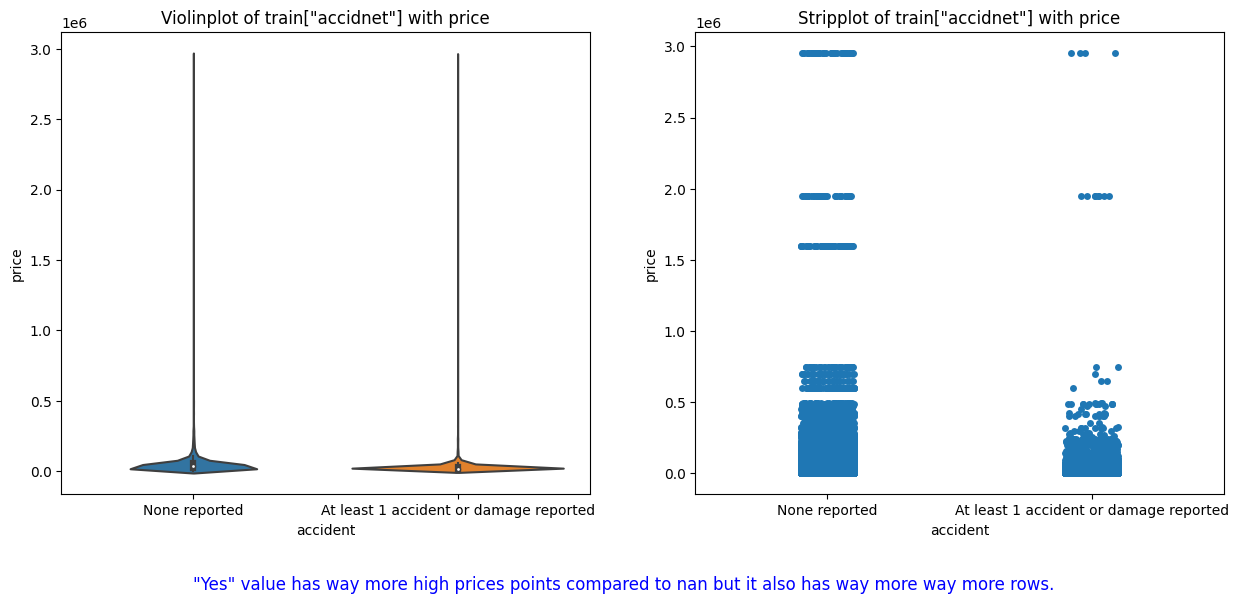

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.violinplot(x='accident', y='price', data=dummy_train)
plt.title('Violinplot of train["accidnet"] with price')
plt.subplot(1,2,2)
sns.stripplot(x='accident', y='price', data=dummy_train.dropna())
plt.title('Stripplot of train["accidnet"] with price')
plt.figtext(0.5, -0.05, '"Yes" value has way more high prices points compared to nan but it also has way more way more rows.', 
            ha='center', fontsize=12, color='blue')

Various imputation tried for accident but leaving the nan values as they are yielded the best results as deducing null values in accident manually with given data is not possible. Since gbdt work well with nan values and there aren't much rows with null values leave them as they are.

# Fuel Type

fuel_type can easily be deduced with given data such as grouping it by brand, model, model_year, engine and it significantly improves the model too.

In [15]:
dummy_train['fuel_type'].value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

now we also have a placeholder which should be replaced with null values.

In [16]:
# train['fuel_type'] = train['fuel_type'].replace(['–', 'not supported'], np.nan)
# test['fuel_type'] = test['fuel_type'].replace(['–', 'not supported'], np.nan)

In [17]:
import pandas as pd

def get_modes(series):
    modes = series.mode() 
    return modes.tolist() if not modes.empty else [None] 
# brand_model_engine_fuel_mappings_train = train.groupby(['brand','model', 'model_year','engine'])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
# brand_model_engine_fuel_mappings_test = test.groupby(['brand','model', 'model_year', 'engine'])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
brand_model_fuel_mappings_train = train.groupby(['brand','model', 'model_year',])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
brand_model_fuel_mappings_test = test.groupby(['brand','model', 'model_year',])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
engine_fuel_map_train = train.groupby('engine')['fuel_type'].agg(get_modes).to_dict()
engine_fuel_map_test = test.groupby('engine')['fuel_type'].agg(get_modes).to_dict()

def impute_fuel_type_by_engine(row, engine_fuel_map):
    if pd.isnull(row['fuel_type']):
        possible_modes = engine_fuel_map.get(row['engine'], [])
        for mode in possible_modes:
            if mode is not None:
                return mode
    return row['fuel_type']

def impute_fuel_type_by_model(row, brand_model_fuel_map):
    if pd.isnull(row['fuel_type']):
        mode = brand_model_fuel_map.get((row['brand'], row['model'], row['model_year']), row['fuel_type'])
        if mode is not row['fuel_type']:
            return mode
    return row['fuel_type']

# def impute_fuel_type_by_model_engine(row, brand_model_enginefuel_map):
#     if pd.isnull(row['fuel_type']):
#         mode = brand_model_fuel_map.get((row['brand'], row['model'], row['model_year'], row['engine']), row['fuel_type'])
#         if mode is not row['fuel_type']:
#             return mode
#     return row['fuel_type']
    
train['fuel_type'] = train.apply(lambda row: impute_fuel_type_by_model(row, brand_model_fuel_mappings_train), axis=1)
train['fuel_type'] = train.apply(lambda row: impute_fuel_type_by_model(row, brand_model_fuel_mappings_test), axis=1)

test['fuel_type'] = test.apply(lambda row: impute_fuel_type_by_model(row, brand_model_fuel_mappings_test), axis=1)
test['fuel_type'] = test.apply(lambda row: impute_fuel_type_by_model(row, brand_model_fuel_mappings_train), axis=1)

train['fuel_type'] = train.apply(lambda row: impute_fuel_type_by_engine(row, engine_fuel_map_train), axis=1)
train['fuel_type'] = train.apply(lambda row: impute_fuel_type_by_engine(row, engine_fuel_map_test), axis=1)

test['fuel_type'] = test.apply(lambda row: impute_fuel_type_by_engine(row, engine_fuel_map_test), axis=1)
test['fuel_type'] = test.apply(lambda row: impute_fuel_type_by_engine(row, engine_fuel_map_train), axis=1)

print('train', train['fuel_type'].isnull().sum())
print('test', test['fuel_type'].isnull().sum())


train 12
test 4


In [18]:
train['fuel_type'].value_counts()

fuel_type
Gasoline          170889
Hybrid              6940
E85 Flex Fuel       5406
Diesel              3956
–                    781
Plug-In Hybrid       533
not supported         16
Name: count, dtype: int64

placeholder replaced with original values, fill the rest with mode

In [19]:
train['fuel_type'] = train['fuel_type'].fillna('Gasoline')
test['fuel_type'] = test['fuel_type'].fillna('Gasoline')

> That's it folks, this is the best possible imputation from my experiments and it would definitly increase model performance. And for continuous cols, no need for scaling as if intended model is gbdt then scaling has minimal effect on performance and the effect is mostly negative.